# fastMRI
Python 3.6+, Tensorflow 2.0.0-dev20190601

In [94]:
ll -h /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5

-rw-rw-r-- 1 ubuntu 91M May 31 18:39 /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5


In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [98]:
import cs230_project_utilities as utils

# Convert and preprocess raw data to create a TFRecord dataset
Visualize the effects of various preprocessing techniques

## Preprocessing: only basic center crop and reshape

In [183]:
# Convert raw data to TFRecord dataset

# Location of .h5 files
raw_data_locations = ['/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5']

# Destination
tfrecord_directory = 'fastmri-test-tfrecords'
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files(raw_data_locations,
                                                        tfrecord_directory,
                                                        coils='single',
                                                        keep_original_reconstruction=True,
                                                        perform_subsampling=False)


# Load data

data_locations = os.path.join(tfrecord_directory, 'shard-0.tfrecord')
dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=40,
                                     load_original_reconstruction=False,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     perform_data_augmentation=False)

# Get first batch
batch = next(iter(dataset))
x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri._combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape

Converting file 0 at b'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5' to TFRecords...
Loading dataset... Shuffle items? True. Shuffle buffer: 40


((128, 128), (128, 128))

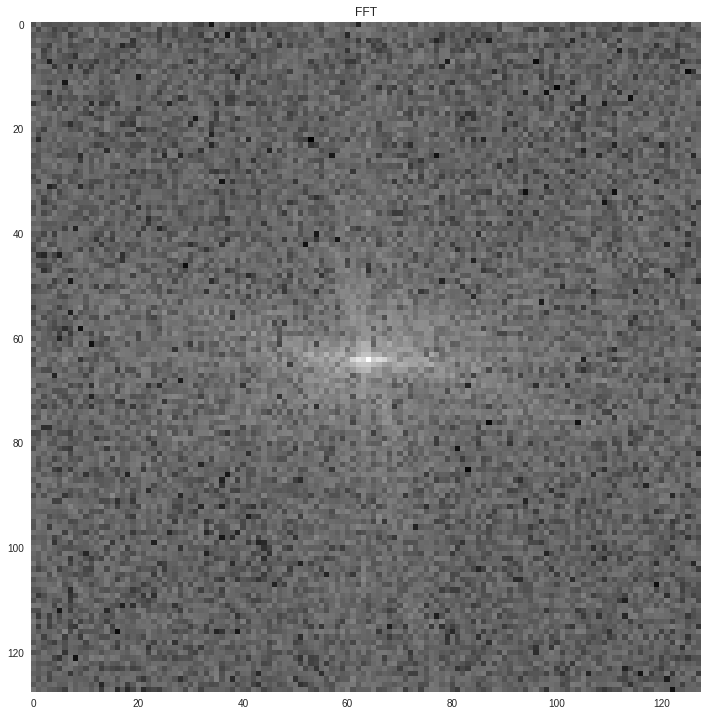

In [184]:
plt.title('FFT')
utils.plot.imshowfft(x)

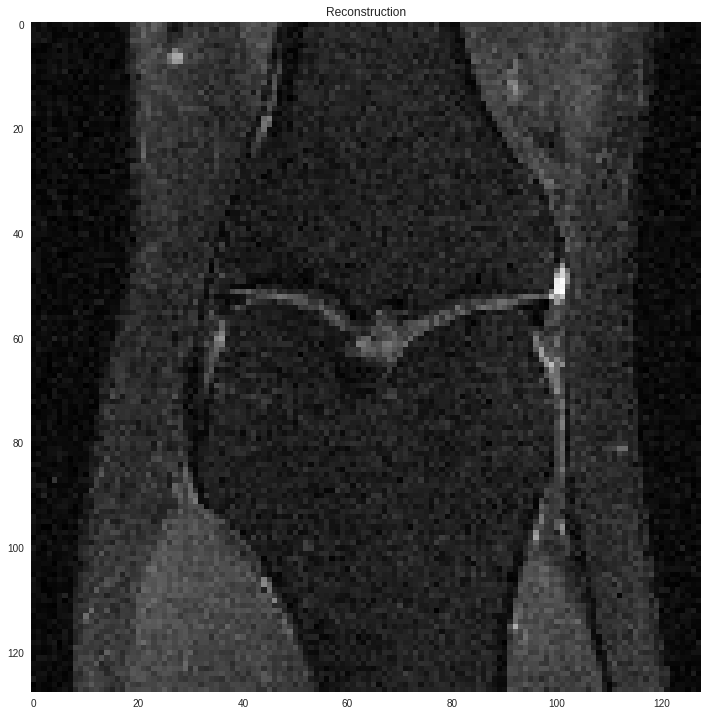

In [185]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)

## Preprocessing: 1) standard reshape and crop and 2) use mask to subsample FFTs

In [186]:
# Convert raw data to TFRecord dataset

# Location of .h5 files
raw_data_locations = ['/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5']

# Destination
tfrecord_directory = 'fastmri-test-tfrecords'
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files(raw_data_locations,
                                                        tfrecord_directory,
                                                        coils='single',
                                                        keep_original_reconstruction=True,
                                                        perform_subsampling=True)


# Load data

data_locations = os.path.join(tfrecord_directory, 'shard-0.tfrecord')
dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=40,
                                     load_original_reconstruction=False,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     perform_data_augmentation=False)

# Get first batch
batch = next(iter(dataset))
x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri._combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape

Converting file 0 at b'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5' to TFRecords...
Loading dataset... Shuffle items? True. Shuffle buffer: 40


((128, 128), (128, 128))

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


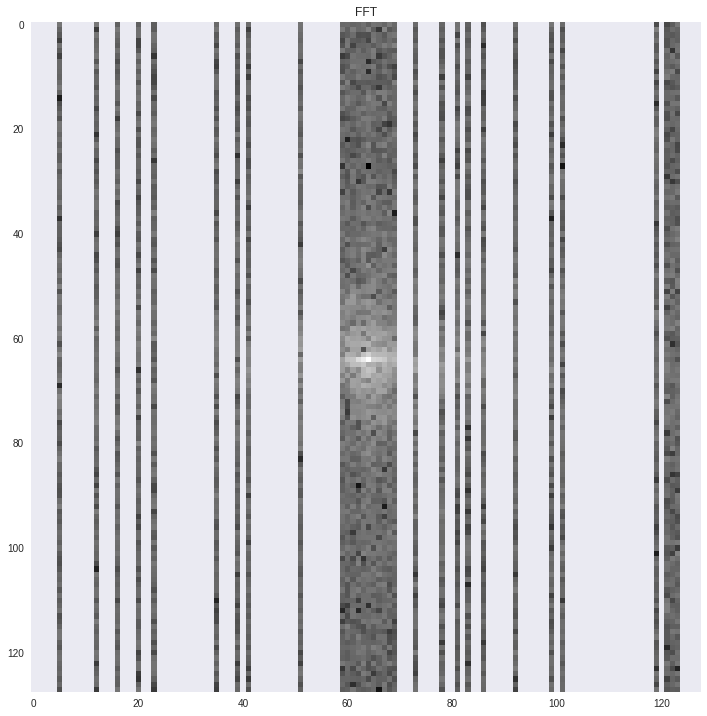

In [187]:
plt.title('FFT')
utils.plot.imshowfft(x)

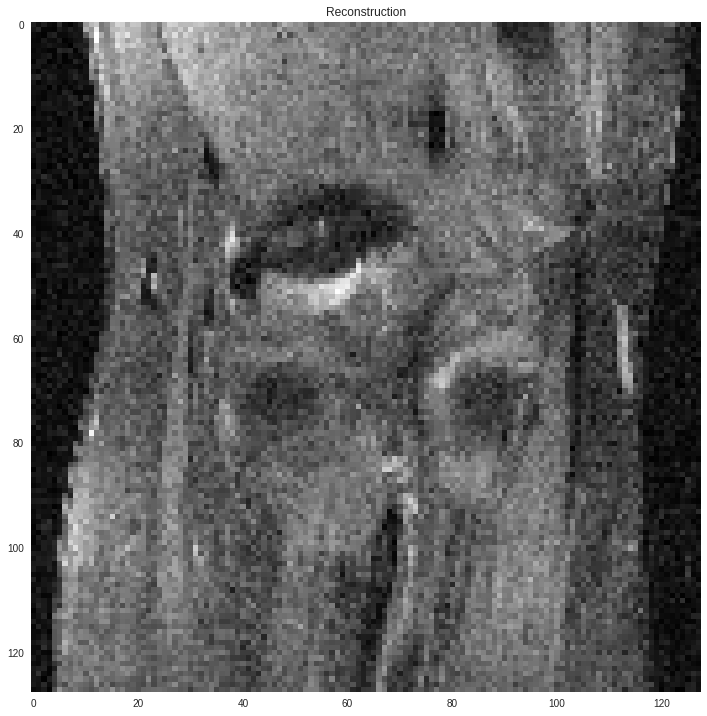

In [188]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)

## Preprocessing: 1) standard reshapea and crop, 2) subsample, and 3) tile and randomly crop reflections (as data augmentation)

In [189]:
# Convert raw data to TFRecord dataset

# Location of .h5 files
raw_data_locations = ['/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5']

# Destination
tfrecord_directory = 'fastmri-test-tfrecords'
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files(raw_data_locations,
                                                        tfrecord_directory,
                                                        coils='single',
                                                        keep_original_reconstruction=True,
                                                        perform_subsampling=True)


# Load data

data_locations = os.path.join(tfrecord_directory, 'shard-0.tfrecord')
dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=40,
                                     load_original_reconstruction=False,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     perform_data_augmentation=True)

# Get first batch
batch = next(iter(dataset))
x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri._combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape

Converting file 0 at b'/home/ubuntu/cs230/data/fastmri/raw/file1000000.h5' to TFRecords...
Loading dataset... Shuffle items? True. Shuffle buffer: 40


((128, 128), (128, 128))

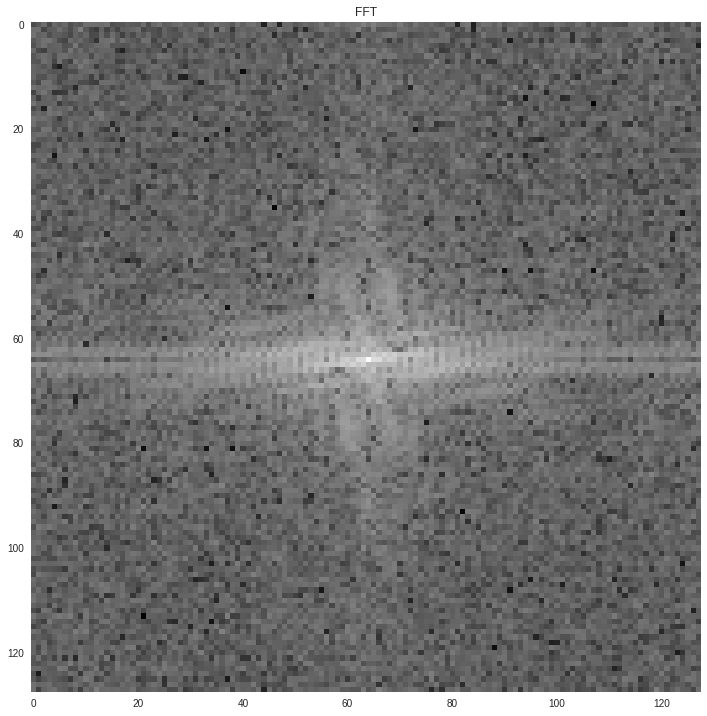

In [190]:
plt.title('FFT')
utils.plot.imshowfft(x)

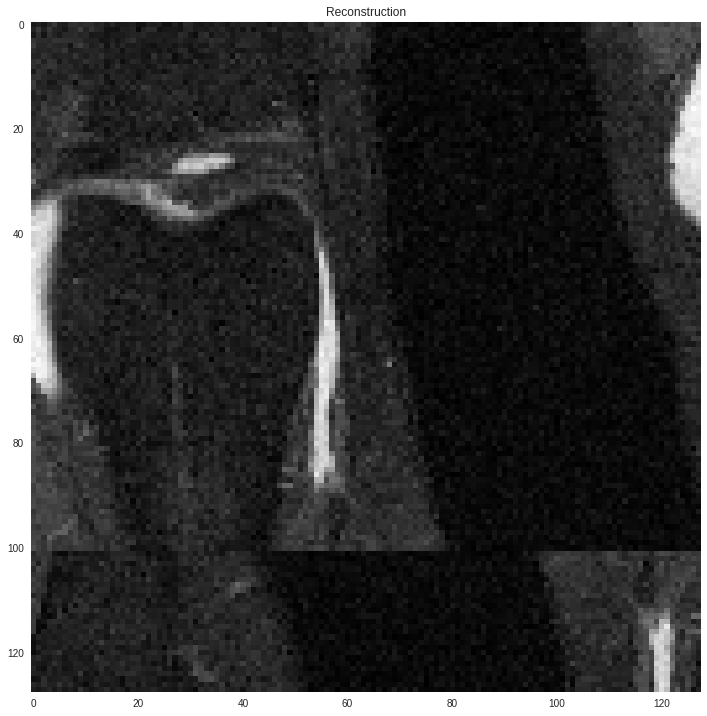

In [191]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)